In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, average_precision_score, auc
import category_encoders as ce
from imblearn.over_sampling import ADASYN
import logging
import joblib

In [5]:
data_temp = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv', index_col=0)
data_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv', index_col=0)

data_temp.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [7]:
data_temp["trans_date_trans_time"] = pd.to_datetime(data_temp["trans_date_trans_time"])
data_test["trans_date_trans_time"] = pd.to_datetime(data_test["trans_date_trans_time"])

data_temp['transaction_hour'] = data_temp['trans_date_trans_time'].dt.hour
data_test['transaction_hour'] = data_test['trans_date_trans_time'].dt.hour

data_temp["dob"] = pd.to_datetime(data_temp["dob"])
data_test["dob"] = pd.to_datetime(data_test["dob"])

data_temp['year_of_birth'] = data_temp["dob"].dt.year
data_test['year_of_birth'] = data_test["dob"].dt.year

In [8]:
categorial_columns = [column for column in data_temp.columns if data_temp[column].dtype == object]
categorial_columns

['merchant',
 'category',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'job',
 'trans_num']

In [9]:
data_temp[categorial_columns].nunique()

merchant         693
category          14
first            352
last             481
gender             2
street           983
city             894
state             51
job              494
trans_num    1296675
dtype: int64

In [10]:
data_temp.drop(['merchant', 'cc_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'trans_num','trans_date_trans_time'], axis=1, inplace=True)
data_test.drop(['merchant', 'cc_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'trans_num','trans_date_trans_time'], axis=1, inplace=True)

In [11]:
categorial_columns = [column for column in data_temp.columns if data_temp[column].dtype == object]
categorial_columns

['category', 'gender', 'state', 'job']

# EDA

([<matplotlib.patches.Wedge at 0x7f5254f13150>,
 [Text(1.0998181114699639, 0.02000304183473917, 'Is Fraud'),
  Text(-1.0998181097434538, -0.020003136762423008, 'Is not Fraud')],
 [Text(0.5999007880745257, 0.010910750091675908, '0.6%'),
  Text(-0.5999007871327929, -0.010910801870412549, '99.4%')])

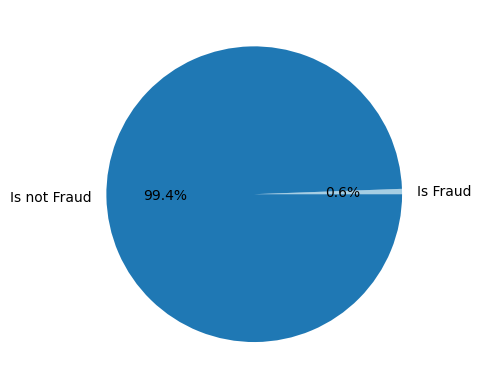

In [12]:
fraud_count = [data_temp[data_temp['is_fraud'] == 1].shape[0], data_temp[data_temp['is_fraud'] == 0].shape[0]]
fraud_labels = ['Is Fraud', 'Is not Fraud']
colors = sns.color_palette("Paired")
plt.pie(x=fraud_count, labels=fraud_labels, colors=colors, autopct='%1.1f%%')

In [13]:
data_temp.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Text(0, 0.5, 'Доля в общем числе, %')

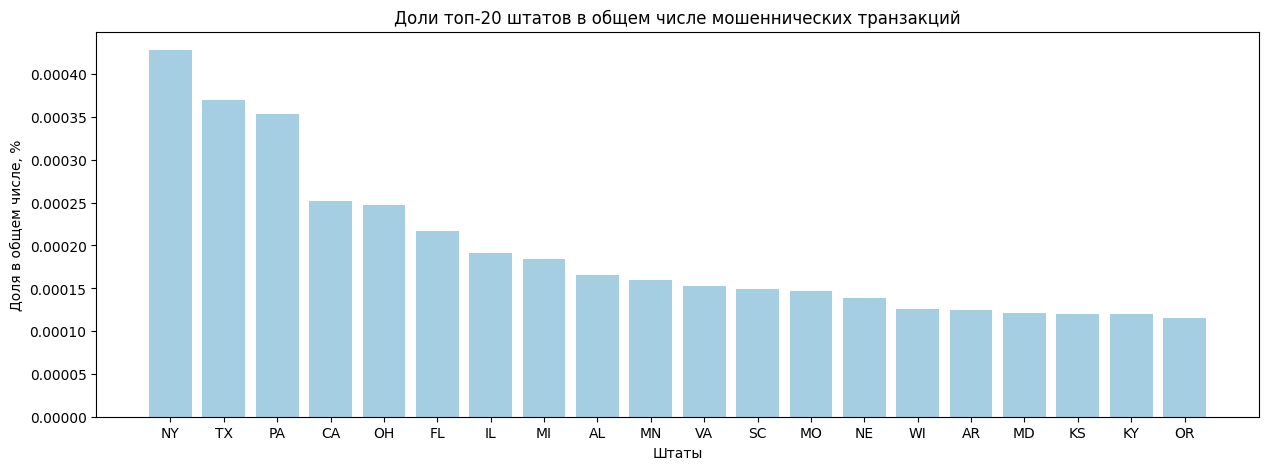

In [14]:
states_counts = data_temp[data_temp['is_fraud'] == 1]['state'].value_counts()[:20]
plt.figure(figsize=(15, 5))
plt.bar(states_counts.index, states_counts.values / data_temp.shape[0], color=colors[0])
plt.title('Доли топ-20 штатов в общем числе мошеннических транзакций')
plt.xlabel("Штаты")
plt.ylabel("Доля в общем числе, %")

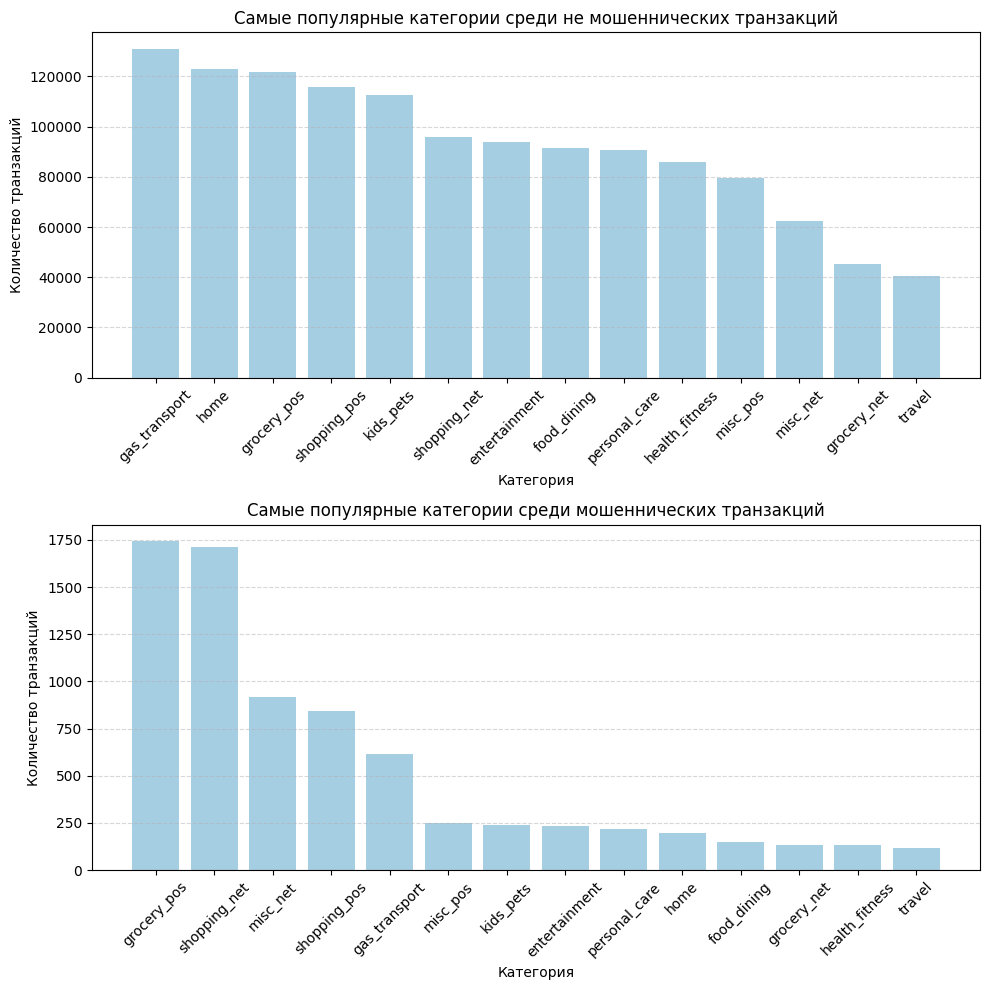

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

category_counts_notfraud = data_temp[data_temp['is_fraud'] == 0]['category'].value_counts()

axes[0].bar(category_counts_notfraud.index, category_counts_notfraud.values, color=colors[0])
axes[0].set_title("Самые популярные категории среди не мошеннических транзакций")
axes[0].set_xlabel("Категория")
axes[0].set_ylabel("Количество транзакций")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].tick_params(axis='x', rotation=45)

category_counts_fraud = data_temp[data_temp['is_fraud'] == 1]['category'].value_counts()

axes[1].bar(category_counts_fraud.index, category_counts_fraud.values, color=colors[0])
axes[1].set_title("Самые популярные категории среди мошеннических транзакций")
axes[1].set_xlabel("Категория")
axes[1].set_ylabel("Количество транзакций")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=45)

fig.tight_layout()

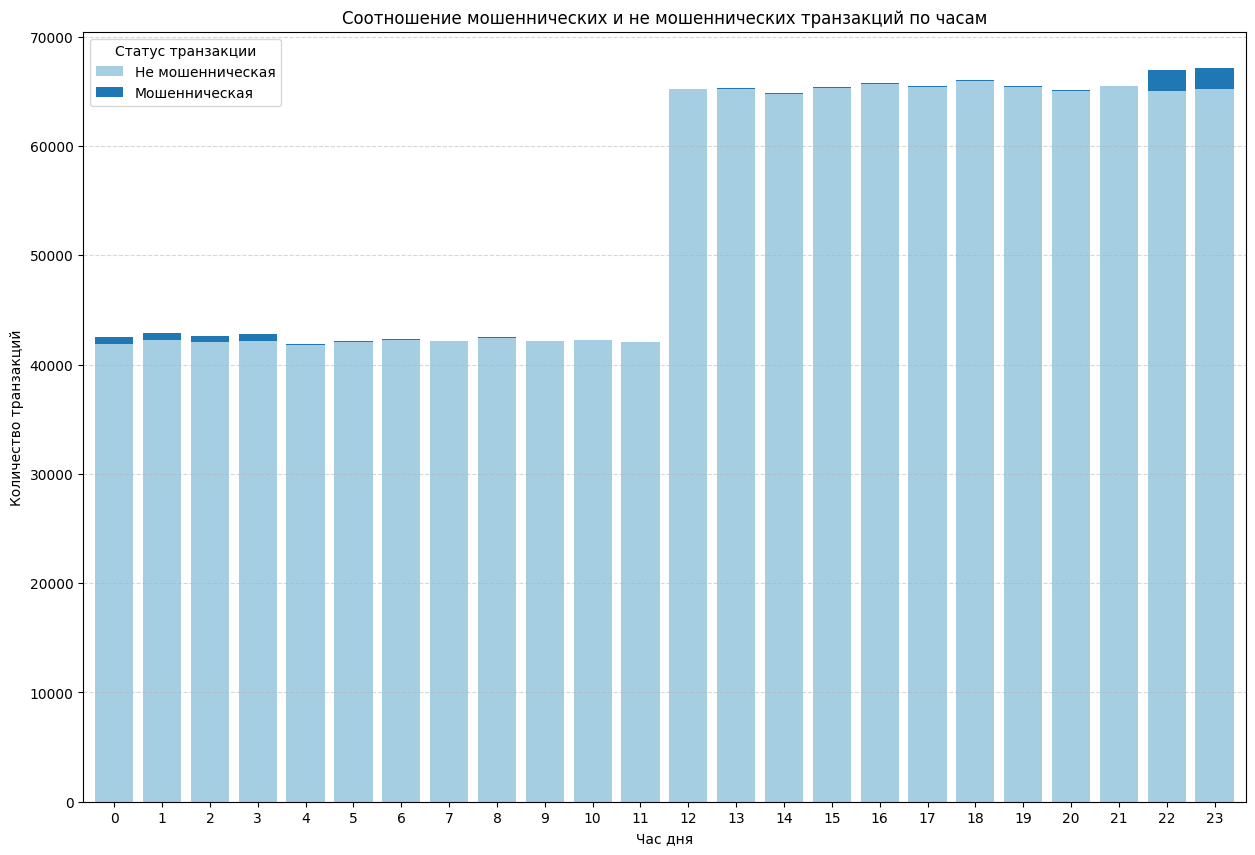

In [16]:
hourly_fraud_counts = data_temp.groupby(['transaction_hour', 'is_fraud']).size()
hourly_fraud_pivot = hourly_fraud_counts.unstack(fill_value=0)
hourly_fraud_pivot = hourly_fraud_pivot.rename(columns={0: 'Не мошенническая', 1: 'Мошенническая'})

plt.figure(figsize=(15, 10))
hourly_fraud_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), width=0.8, color=colors)

plt.xlabel("Час дня")
plt.ylabel("Количество транзакций")
plt.title("Соотношение мошеннических и не мошеннических транзакций по часам")
plt.xticks(range(24), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Статус транзакции")

In [17]:
continuous_columns = [column for column in data_temp.columns if data_temp[column].dtype == np.int64 or data_temp[column].dtype == np.float64]
continuous_columns

['amt',
 'lat',
 'long',
 'city_pop',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [18]:
correlations = np.corrcoef(data_temp[continuous_columns].T)

Text(0.5, 1.0, 'Корреляционная матрица признаков')

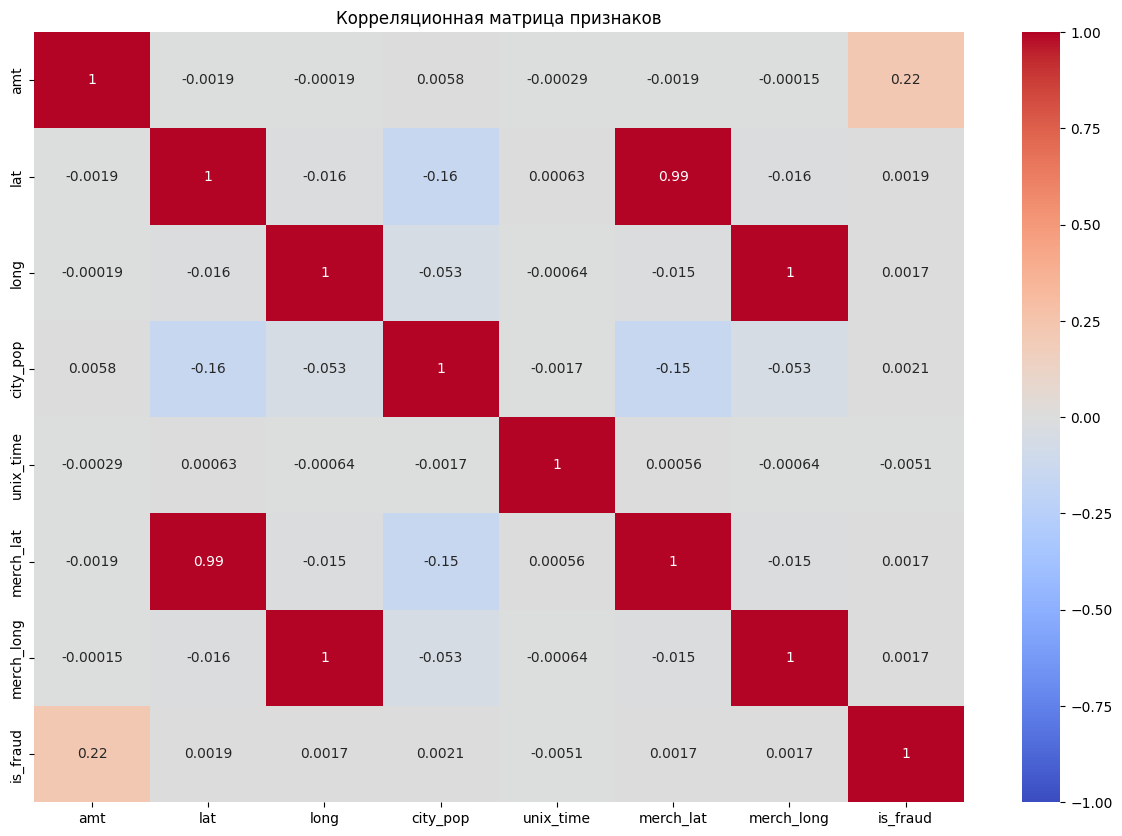

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
           xticklabels=continuous_columns, yticklabels=continuous_columns)
plt.xticks(rotation=0)

plt.title('Корреляционная матрица признаков')

In [20]:
data_temp.drop(['long', 'lat'], axis=1, inplace=True)
data_test.drop(['long', 'lat'], axis=1, inplace=True)

# Data preparation

In [22]:
X = data_temp.drop(columns=['is_fraud'])
y = data_temp['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
X_test = data_test.drop(columns=['is_fraud'])
y_test = data_test['is_fraud']

In [24]:
encoder = ce.TargetEncoder(cols=categorial_columns, smoothing=1.0)

encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

In [25]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [26]:
def model_performance(y_pred, y_true):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# HistGradientBoostingClassifier 

In [29]:
logging.getLogger('optuna').setLevel(logging.WARNING)

In [30]:
model_gbc = HistGradientBoostingClassifier()
model_gbc.fit(X_train_resampled, y_train_resampled)

y_pred_gbc = model_gbc.predict(X_test)

model_performance(y_pred_gbc, y_test)

Accuracy: 0.9888
Precision: 0.2052
Recall: 0.6620
F1-Score: 0.3133

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.21      0.66      0.31      2145

    accuracy                           0.99    555719
   macro avg       0.60      0.83      0.65    555719
weighted avg       1.00      0.99      0.99    555719


Confusion Matrix:
[[548074   5500]
 [   725   1420]]


In [33]:
def objective_gbc(trial):

    params = {
        'max_iter': trial.suggest_int('max_iter', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'random_state': 42,
        'early_stopping': True,
        'n_iter_no_change': 10
    }

    model_gbc = HistGradientBoostingClassifier(**params)
    
    model_gbc.fit(X_train_resampled, y_train_resampled)
    val_pred_gbc = model_gbc.predict_proba(X_val)[:, 1]
    
    score_gbc = average_precision_score(y_val, val_pred_gbc)
    return score_gbc

study_gbc = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_gbc.optimize(objective_gbc, n_trials=100)

print("Лучшее значение PR-AUC:", study_gbc.best_trial.value)
print("Лучшие гиперпараметры:", study_gbc.best_trial.params)

best_params_gbc = study_gbc.best_trial.params

[I 2025-05-29 17:01:21,337] A new study created in memory with name: no-name-e367b305-4bc9-4ada-a567-c9f13a9bff23
[I 2025-05-29 17:01:57,390] Trial 0 finished with value: 0.8813928826923342 and parameters: {'max_iter': 173, 'learning_rate': 0.06697193820268448, 'max_depth': 10}. Best is trial 0 with value: 0.8813928826923342.
[I 2025-05-29 17:02:12,984] Trial 1 finished with value: 0.8637002565984273 and parameters: {'max_iter': 69, 'learning_rate': 0.1212992378115043, 'max_depth': 11}. Best is trial 0 with value: 0.8813928826923342.
[I 2025-05-29 17:02:32,818] Trial 2 finished with value: 0.379815219985955 and parameters: {'max_iter': 210, 'learning_rate': 0.056976923164045845, 'max_depth': 1}. Best is trial 0 with value: 0.8813928826923342.
[I 2025-05-29 17:02:59,307] Trial 3 finished with value: 0.8985470327249225 and parameters: {'max_iter': 148, 'learning_rate': 0.17342487433822876, 'max_depth': 6}. Best is trial 3 with value: 0.8985470327249225.
[I 2025-05-29 17:03:34,431] Trial 

Лучшее значение PR-AUC: 0.9291050742440445
Лучшие гиперпараметры: {'max_iter': 290, 'learning_rate': 0.16662353157964904, 'max_depth': 6}


In [35]:
best_model_gbc = HistGradientBoostingClassifier(**best_params_gbc, random_state=42)
best_model_gbc.fit(X_train_resampled, y_train_resampled)

y_pred_best_model_gbc = best_model_gbc.predict(X_test)

model_performance(y_pred_best_model_gbc, y_test)

Accuracy: 0.9960
Precision: 0.4830
Recall: 0.5688
F1-Score: 0.5224

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.48      0.57      0.52      2145

    accuracy                           1.00    555719
   macro avg       0.74      0.78      0.76    555719
weighted avg       1.00      1.00      1.00    555719


Confusion Matrix:
[[552268   1306]
 [   925   1220]]


# XGBClassifier

In [36]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

model_performance(y_pred_xgb, y_test)

Accuracy: 0.9980
Precision: 0.8291
Recall: 0.6084
F1-Score: 0.7018

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.83      0.61      0.70      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.80      0.85    555719
weighted avg       1.00      1.00      1.00    555719


Confusion Matrix:
[[553305    269]
 [   840   1305]]


In [38]:
def objective_xgb(trial):
    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 650.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model_xgb = xgb.XGBClassifier(**params_xgb)

    model_xgb.fit(X_train, y_train)
    val_pred_xgb = model_xgb.predict_proba(X_val)[:, 1]
    
    score_xgb = average_precision_score(y_val, val_pred_xgb)
    return score_xgb

study_xgb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_xgb.optimize(objective_xgb, n_trials=100)

print("Лучшее значение PR-AUC:", study_xgb.best_trial.value)
print("Лучшие гиперпараметры:", study_xgb.best_trial.params)
best_params_xgb = study_xgb.best_trial.params

[I 2025-05-29 18:05:35,089] A new study created in memory with name: no-name-a6c36681-d088-4ac7-96de-30dda07c0992
[I 2025-05-29 18:05:44,308] Trial 0 finished with value: 0.8852770232073317 and parameters: {'n_estimators': 263, 'learning_rate': 0.06834113798875889, 'max_depth': 4, 'scale_pos_weight': 495.3837954201095}. Best is trial 0 with value: 0.8852770232073317.
[I 2025-05-29 18:06:04,468] Trial 1 finished with value: 0.9474792414582756 and parameters: {'n_estimators': 239, 'learning_rate': 0.060216501208466264, 'max_depth': 11, 'scale_pos_weight': 116.80318838314425}. Best is trial 1 with value: 0.9474792414582756.
[I 2025-05-29 18:06:25,757] Trial 2 finished with value: 0.9396613121204389 and parameters: {'n_estimators': 292, 'learning_rate': 0.04270935650714888, 'max_depth': 9, 'scale_pos_weight': 526.2823361135278}. Best is trial 1 with value: 0.9474792414582756.
[I 2025-05-29 18:06:41,872] Trial 3 finished with value: 0.9243914730154393 and parameters: {'n_estimators': 215, '

Лучшее значение PR-AUC: 0.9709648295734818
Лучшие гиперпараметры: {'n_estimators': 500, 'learning_rate': 0.09211572596743685, 'max_depth': 8, 'scale_pos_weight': 90.04720916784936}


In [39]:
best_model_xgbc = xgb.XGBClassifier(**best_params_xgb)
best_model_xgbc.fit(X_train, y_train)

y_pred_best_model_xgbc = best_model_xgbc.predict(X_test)

model_performance(y_pred_best_model_xgbc, y_test)

Accuracy: 0.9976
Precision: 0.7629
Recall: 0.5534
F1-Score: 0.6414

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.55      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.78      0.82    555719
weighted avg       1.00      1.00      1.00    555719


Confusion Matrix:
[[553205    369]
 [   958   1187]]


# LightGBM 

In [40]:
model_lgbm = lgb.LGBMClassifier()
model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)

model_performance(y_pred_lgbm, y_test)

[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1697
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
Accuracy: 0.9915
Precision: 0.2208
Recall: 0.4783
F1-Score: 0.3021

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.22      0.48      0.30      2145

    accuracy                           0.99    555719
   macro avg       0.61      0.74      0.65    555719
weighted avg       0.99      0.99      0.99    555719


Confusion Matrix:
[[

In [42]:
def objective_lgbm(trial):
    params_lgbm = {
        'objective': 'binary',
        'metric': 'average_precision',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 650.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    model_lgbm = lgb.LGBMClassifier(**params_lgbm)
    
    model_lgbm.fit(X_train, y_train)
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    
    score_lgbm = average_precision_score(y_val, val_pred_lgbm)
    return score_lgbm

study_lgbm = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_lgbm.optimize(objective_lgbm, n_trials=100)

print("Лучшее значение PR-AUC:", study_lgbm.best_trial.value)
print("Лучшие гиперпараметры:", study_lgbm.best_trial.params)
best_params_lgbm = study_lgbm.best_trial.params

[I 2025-05-29 18:54:24,128] A new study created in memory with name: no-name-fc42f79d-c7cb-4abf-9f63-f24a1042decf
[I 2025-05-29 18:54:37,635] Trial 0 finished with value: 0.0357803033684286 and parameters: {'n_estimators': 258, 'learning_rate': 0.09561207682687028, 'max_depth': 10, 'scale_pos_weight': 413.088493143989}. Best is trial 0 with value: 0.0357803033684286.
[I 2025-05-29 18:54:54,872] Trial 1 finished with value: 0.9402378469496302 and parameters: {'n_estimators': 342, 'learning_rate': 0.04960693057676991, 'max_depth': 8, 'scale_pos_weight': 223.77473612929734}. Best is trial 1 with value: 0.9402378469496302.
[I 2025-05-29 18:55:00,512] Trial 2 finished with value: 0.44397551683267306 and parameters: {'n_estimators': 205, 'learning_rate': 0.06182619696574396, 'max_depth': 1, 'scale_pos_weight': 30.84309056378232}. Best is trial 1 with value: 0.9402378469496302.
[I 2025-05-29 18:55:25,181] Trial 3 finished with value: 0.9471760898987318 and parameters: {'n_estimators': 499, 'l

Лучшее значение PR-AUC: 0.9566110500609566
Лучшие гиперпараметры: {'n_estimators': 482, 'learning_rate': 0.059282982003874135, 'max_depth': 12, 'scale_pos_weight': 99.17698505940574}


In [43]:
best_model_lightgbm = lgb.LGBMClassifier(**best_params_lgbm)
best_model_lightgbm.fit(X_train, y_train)

y_pred_best_model_lightgbm = best_model_lightgbm.predict(X_test)

model_performance(y_pred_best_model_lightgbm, y_test)

Accuracy: 0.9956
Precision: 0.4516
Recall: 0.6196
F1-Score: 0.5224

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.45      0.62      0.52      2145

    accuracy                           1.00    555719
   macro avg       0.73      0.81      0.76    555719
weighted avg       1.00      1.00      1.00    555719


Confusion Matrix:
[[551960   1614]
 [   816   1329]]


# Сравнение ROC-кривых моделей

In [51]:
score_gbc = best_model_gbc.predict_proba(X_test)[:, 1]
score_xgbc = best_model_xgbc.predict_proba(X_test)[:, 1]
score_lightgbm = best_model_lightgbm.predict_proba(X_test)[:, 1]

fpr_1, tpr_1, _ = roc_curve(y_test, score_gbc)
roc_auc_gbc = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, score_xgbc)
roc_auc_xgbc = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test, score_lightgbm)
roc_auc_lightgbm = auc(fpr_3, tpr_3)

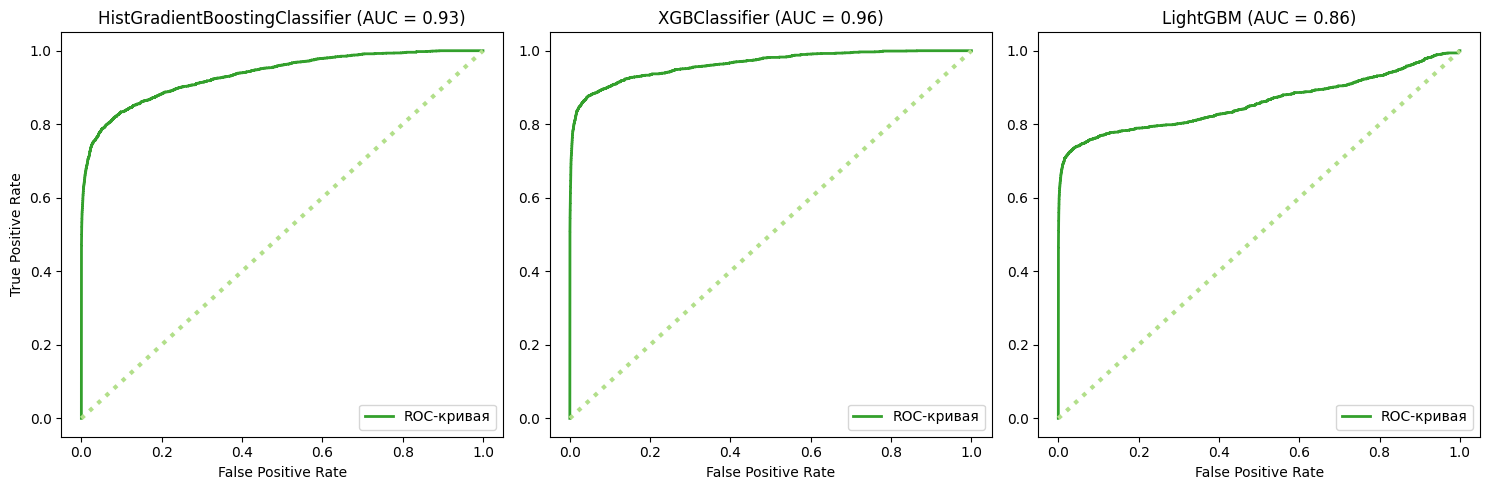

In [56]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr_1, tpr_1, color=colors[3], lw=2, label='ROC-кривая')
plt.plot([0, 1], [0, 1], color=colors[2], lw=3, linestyle=':')
plt.title('HistGradientBoostingClassifier (AUC = {:.2f})'.format(roc_auc_gbc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.subplot(1, 3, 2)
plt.plot(fpr_2, tpr_2, color=colors[3], lw=2, label='ROC-кривая')
plt.plot([0, 1], [0, 1], color=colors[2], lw=3, linestyle=':')
plt.title('XGBClassifier (AUC = {:.2f})'.format(roc_auc_xgbc))
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(fpr_3, tpr_3, color=colors[3], lw=2, label='ROC-кривая')
plt.plot([0, 1], [0, 1], color=colors[2], lw=3, linestyle=':')
plt.title('LightGBM (AUC = {:.2f})'.format(roc_auc_lightgbm))
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()

# Сохранение модели

In [59]:
joblib.dump(best_model_xgbc, 'best_model.pkl')

['best_model.pkl']